In [1]:
import numpy as np                   # array, vector, matrix calculations
import os                            # file-handling
import pandas as pd                  # DataFrame handling
import shap                          # for consistent, signed variable importance measurements
import xgboost as xgb                # gradient boosting machines (GBMs)

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all dataframe columns in notebook

%matplotlib inline

np.random.seed(12345)                # set random seed for reproducibility

In [2]:
shap.__version__

'0.28.0'

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

In [4]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [5]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [6]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1] 

,DEFAULT_NEXT_MONTH
LIMIT_BAL,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


In [7]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

# (-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

In [8]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.95    # 95%/5% train/test split - for faster shap on test set 

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 28465, columns = 25
Test data rows = 1535, columns = 25


In [10]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'logloss',                   # stop training based on
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 12345                               # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      50,                       # 
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 iterations (trees) without increase in AUC
                      verbose_eval=True)        # display iteration progress


[0]	train-logloss:0.511578	eval-logloss:0.530102
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[1]	train-logloss:0.498846	eval-logloss:0.518
[2]	train-logloss:0.488667	eval-logloss:0.508652
[3]	train-logloss:0.48006	eval-logloss:0.500849
[4]	train-logloss:0.472905	eval-logloss:0.494238
[5]	train-logloss:0.467001	eval-logloss:0.489148
[6]	train-logloss:0.461843	eval-logloss:0.484578
[7]	train-logloss:0.457288	eval-logloss:0.480721
[8]	train-logloss:0.453418	eval-logloss:0.477667
[9]	train-logloss:0.45031	eval-logloss:0.475348
[10]	train-logloss:0.447321	eval-logloss:0.473216
[11]	train-logloss:0.444844	eval-logloss:0.471286
[12]	train-logloss:0.442521	eval-logloss:0.46983
[13]	train-logloss:0.440667	eval-logloss:0.468618
[14]	train-logloss:0.438974	eval-logloss:0.467353
[15]	train-logloss:0.437372	eval-logloss:0.466379
[16]	train-logloss:0.436018	eval-logloss:0.46552
[17]	train-logloss

In [11]:
# calculate logloss residual manually
# reset test index for merge of shap values later
test_yhat = test.copy(deep=True)
test_yhat.reset_index(drop=True, inplace=True)

yhat = 'p_DEFAULT_NEXT_MONTH'
test_yhat[yhat] = pd.DataFrame(xgb_model.predict(xgb.DMatrix(test[X]))) 
test_yhat['r_DEFAULT_NEXT_MONTH'] = -test_yhat[y]*np.log(test_yhat['p_DEFAULT_NEXT_MONTH']) + \
                                     -(1 - test_yhat[y])*np.log(1 - test_yhat['p_DEFAULT_NEXT_MONTH'])

In [12]:
test_yhat['r_DEFAULT_NEXT_MONTH'].mean() # confirm this matches xgb eval loss - yes

0.4594770849612617

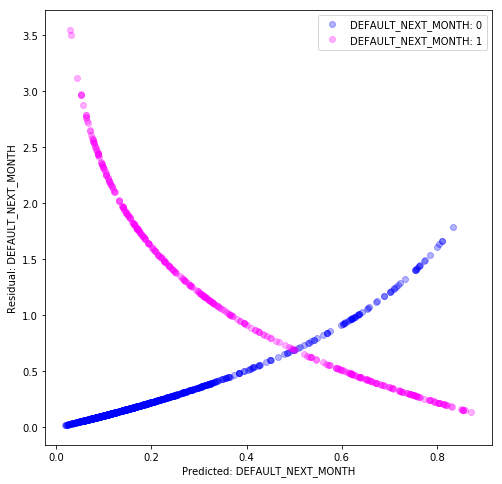

In [13]:
# plot test residuals 
groups = test_yhat.groupby('DEFAULT_NEXT_MONTH') # define groups
fig, ax_ = plt.subplots(figsize=(8, 8))          # initialize figure

plt.xlabel('Predicted: DEFAULT_NEXT_MONTH')
plt.ylabel('Residual: DEFAULT_NEXT_MONTH')

# plot groups with appropriate color
color_list = ['blue', 'magenta'] 
c_idx = 0
for name, group in groups:
    ax_.plot(group.p_DEFAULT_NEXT_MONTH, group.r_DEFAULT_NEXT_MONTH, label=' '.join(['DEFAULT_NEXT_MONTH:', str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

_ = ax_.legend(loc=1) # legend

In [14]:
# sort to confirm highest residuals match plot
test_yhat_sorted = test_yhat.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).reset_index(drop=True)
test_yhat_sorted

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
0,11571,200000,1,2,2,30,-2,-2,-2,-2,-2,-2,48492,49934,24753,123439,132269,129224,20294,24891,125171,17816,26269,4349,1,0.028777,3.548167
1,16209,360000,2,1,1,35,-2,-1,0,-1,-1,-1,94657,34529,106276,73331,7759,31840,45000,100000,73427,7759,31840,12577,1,0.030027,3.505650
2,5287,520000,2,1,2,33,0,0,0,0,0,0,485298,499489,413019,168770,168964,191188,22000,18300,26500,30000,27000,25000,1,0.044292,3.116952
3,4321,420000,2,1,2,34,-1,-1,-1,-1,-1,-1,13207,6184,6692,1039,1039,1503,6222,9723,1045,1042,1509,9215,1,0.050997,2.975996
4,26193,200000,2,2,1,29,-2,-2,-2,-2,-2,-2,8350,14139,3580,6386,868,10415,14185,7425,6386,868,10647,4320,1,0.051382,2.968467
5,16277,300000,2,1,2,31,0,0,0,-1,-1,0,34515,60700,33843,5045,10288,12565,30000,5000,5045,10288,5000,5000,1,0.051536,2.965469
6,13402,420000,2,3,2,27,-2,-2,-1,0,0,0,1486,-3341,116659,119808,122181,130976,2679,120000,5003,5000,10979,5016,1,0.056422,2.874897
7,5181,340000,2,1,2,47,0,0,0,0,0,0,326065,339260,332032,280450,282510,281197,20070,12747,9582,20070,18092,20102,1,0.061636,2.786510
8,10080,200000,2,1,1,37,-1,-1,-1,0,0,0,3660,16991,19200,18856,14301,913,17302,20891,7377,2000,0,127188,1,0.061721,2.785131
9,6552,260000,2,2,2,27,0,0,0,0,0,-1,19713,22378,24836,32816,42816,8938,3000,3000,10000,10000,8938,2000,1,0.062791,2.767940


In [15]:
xgb_model.set_attr(objective='binary:logistic')
explainer = shap.TreeExplainer(xgb_model, test_yhat[X], feature_dependence='independent', model_output='logloss')
shap_values = explainer.shap_values(test_yhat[X], y=test_yhat[y])         # long step (hours!)
np.savetxt('shap_error_values.csv', shap_values, delimiter=',')           # save    

100%|===================| 1534/1535 [02:29<00:00]        

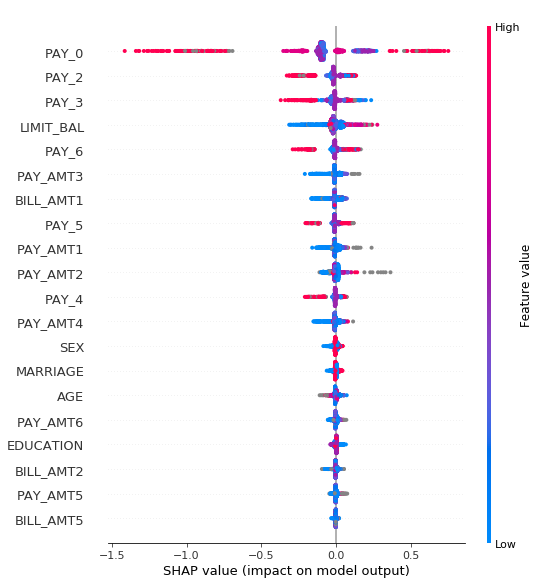

In [16]:
# plot Shapley variable importance summary 
shap.summary_plot(shap_values, test_yhat[xgb_model.feature_names])

In [17]:
# find row in test data with highest residual
row_id = test_yhat_sorted.loc[0, 'ID']
row = test_yhat[test_yhat['ID'] == row_id]
row

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
564,11571,200000,1,2,2,30,-2,-2,-2,-2,-2,-2,48492,49934,24753,123439,132269,129224,20294,24891,125171,17816,26269,4349,1,0.028777,3.548167


In [18]:
row.index[0] # should match row index in shap_values array

564

In [19]:
explainer.expected_value(row['DEFAULT_NEXT_MONTH'].values[0])

1.7884538084459782

In [20]:
shap_values[row.index[0], :].sum()

1.7597287191186257

In [21]:
# reset test data index to find riskiest customer in shap_values 
# sort to find largest positive contributions
s_df = pd.DataFrame(shap_values[row.index[0], :].reshape(23, 1), columns=['Loss Contribs'], index=X)
s_df.sort_values(by='Loss Contribs', inplace=True, ascending=False)

In [22]:
s_df['Loss Contribs']

PAY_AMT2     0.331887
PAY_0        0.241537
PAY_3        0.235923
PAY_AMT3     0.157692
PAY_6        0.138343
LIMIT_BAL    0.134324
PAY_AMT1     0.117129
PAY_2        0.115462
BILL_AMT1    0.073291
PAY_AMT4     0.056519
PAY_AMT5     0.044885
MARRIAGE     0.036415
PAY_4        0.035124
AGE          0.028529
BILL_AMT2    0.027553
PAY_5        0.026219
BILL_AMT4    0.022218
PAY_AMT6     0.020994
BILL_AMT5    0.013092
BILL_AMT6    0.004907
BILL_AMT3   -0.008436
EDUCATION   -0.029950
SEX         -0.063926
Name: Loss Contribs, dtype: float64

In [23]:
# sum of shap values doesn't match logloss?
s_df['Loss Contribs'].sum() + explainer.expected_value(row['DEFAULT_NEXT_MONTH'].values[0])

3.548182527564604